# Web Application for Dog Emotion Classifier

In [1]:
# === 1. Mount Google Drive and set working directory ===
from google.colab import drive
import os

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/BT5153')
print("Current directory:", os.getcwd())

ValueError: mount failed

### Load Packages

In [ ]:
# Install packages
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install -q streamlit

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


### Web Application

In [ ]:
%%writefile app.py
import streamlit as st
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms
import cv2
from transformers import GPT2Tokenizer, GPTNeoForCausalLM
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import torch.nn.functional as F
import os
from sklearn.preprocessing import LabelEncoder
import gdown
import numpy as np
import joblib

# Specify the Google Drive shareable link of your model file
model_url_resnet = 'https://drive.google.com/file/d/1DEh9PMHfdHseM_e0hsLRku7ZY_xyQQCd/view?usp=drive_link'
model_url_le = 'https://drive.google.com/file/d/1WJGquSqWRnw9LH7LZCHpSL4N2lr0X7P-/view?usp=sharing'
# Specify the output path where you want to save the downloaded model file
resnet_path = 'best_resnet_dog_model.pth'
label_encoder = 'label_encoder.joblib'

# Download the model file from Google Drive
gdown.download(model_url_resnet, resnet_path, quiet=False, fuzzy=True)
gdown.download(model_url_le, label_encoder, quiet=False, fuzzy=True)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output)

        loss = output[:, class_idx]
        self.model.zero_grad()
        loss.backward()

        # Get the gradients and activations
        gradients = self.gradients
        activations = self.activations

        weights = gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # Normalize
        return cam

def predict_emotion(image, resnet_model, device, le):
    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = resnet_model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    print("Predicted class index:", predicted.item())
    print("Label encoder classes:", le.classes_)
    print("Predicted class label:", le.classes_[predicted.item()])

    predicted_class = le.classes_[predicted.item()]
    probabilities = probabilities.cpu().numpy()[0]

    return predicted_class, probabilities

def generate_heatmap(image, resnet_model, device):
    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Generate heatmap using GradCAM
    target_layer = resnet_model.layer4[-1]
    gradcam = GradCAM(resnet_model, target_layer)
    heatmap = gradcam.generate_heatmap(image_tensor)

    # Convert the original image to numpy array
    original_img = np.array(image.resize((224, 224)))

    return heatmap, original_img

def overlay_heatmap(heatmap, original_img):
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlay = np.uint8(heatmap_color * 0.4 + original_img * 0.6)
    return overlay

def generate_explanation(predicted_class, probabilities, heatmap, llm_tokenizer, llm_model):
    predicted_class_index = np.argmax(probabilities)

    # Identify the most influential region based on the heatmap
    heatmap_flat = heatmap.flatten()
    top_indices = heatmap_flat.argsort()[-5:]  # Get the indices of the top 5 values
    top_coords = [(idx // heatmap.shape[1], idx % heatmap.shape[1]) for idx in top_indices]

    # Determine the relative region based on the coordinates
    height, width = heatmap.shape
    region = ""
    x_coords, y_coords = zip(*top_coords)
    x_center = sum(x_coords) / len(x_coords)
    y_center = sum(y_coords) / len(y_coords)

    if x_center < height / 3:
        region += "upper "
    elif x_center > 2 * height / 3:
        region += "lower "
    else:
        region += "middle "

    if y_center < width / 3:
        region += "left"
    elif y_center > 2 * width / 3:
        region += "right"
    else:
        region += "center"

    input_text = f"The model predicted the dog's emotion as {predicted_class} with a probability of {probabilities[predicted_class_index]:.2f}. The most influential region is around the {region} of the image."

    input_ids = llm_tokenizer.encode(input_text, return_tensors='pt')
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

    output = llm_model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=388,
        num_return_sequences=1,
        pad_token_id=llm_tokenizer.eos_token_id
    )

    explanation = llm_tokenizer.decode(output[0], skip_special_tokens=True)

    lines = explanation.split('\n')
    if len(lines) > 1:
        explanation = lines[0]  # Only keep first line

    # If sentences are repeated, just keep one
    sentences = explanation.split('. ')
    unique_sentences = []
    for sentence in sentences:
        if sentence not in unique_sentences and sentence.strip():
            unique_sentences.append(sentence)

    explanation = '. '.join(unique_sentences)

    # Ensure the sentence is end with "."
    if explanation and explanation[-1] != '.':
        explanation += '.'

    return explanation

# Load the trained ResNet model
resnet_model = models.resnet18(pretrained=False)
num_classes = 3  # Set the number of emotion classes
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

# Load the best model weights
best_model_path = 'best_resnet_dog_model.pth'
resnet_model.load_state_dict(torch.load(best_model_path, map_location=device))
resnet_model.eval()

# Load the label encoder
le = LabelEncoder()
# le.classes_ = np.load('label_encoder.npy')
le = joblib.load('label_encoder.joblib')
print(le.classes_)

# Load the LLM tokenizer and model
llm_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
llm_model = GPTNeoForCausalLM.from_pretrained('EleutherAI/gpt-neo-1.3B')

# Streamlit app
st.title("🐾 Dog Emotion Detector")
st.markdown("Upload your dog's picture below to find out what they're feeling!")

uploaded_file = st.file_uploader("Upload Image", type=["png", "jpg", "jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Dog Image", use_container_width=True)

    with st.spinner("Analyzing emotion..."):
        predicted_emotion, probabilities = predict_emotion(image, resnet_model, device, le)
        heatmap, original_img = generate_heatmap(image, resnet_model, device)
        explanation = generate_explanation(predicted_emotion, probabilities, heatmap, llm_tokenizer, llm_model)

    st.subheader(f"Your dog is: **{predicted_emotion}** 🐶")
    st.text_area("Explanation", explanation, height=150)

    col1, col2 = st.columns(2)
    with col1:
        st.image(image, caption="Original Image", use_container_width=True)
    with col2:
        overlay = overlay_heatmap(heatmap, original_img)
        overlay_image = Image.fromarray(overlay)
        st.image(overlay_image, caption="Heatmap Overlay", use_container_width=True)

    if st.button("Upload Another Image"):
        st.rerun()


Overwriting app.py


### Run streamlit from Google Colab

Source: https://medium.com/@aagamanbhattrai/running-a-streamlit-application-in-google-colab-1576b7188c87

#### Install localtunnel

In [ ]:
!npm install localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋
added 22 packages, and audited 23 packages in 5s
⠋
⠋3 packages are looking for funding
⠋  run `npm fund` for details
⠋
2 high severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠋

#### Run the Streamlit App and Expose it with Localtunnel

Click in the url showed

Open logs.txt and enter in the example below "34.29.69.111" from External URL as password when asked (after opening url)
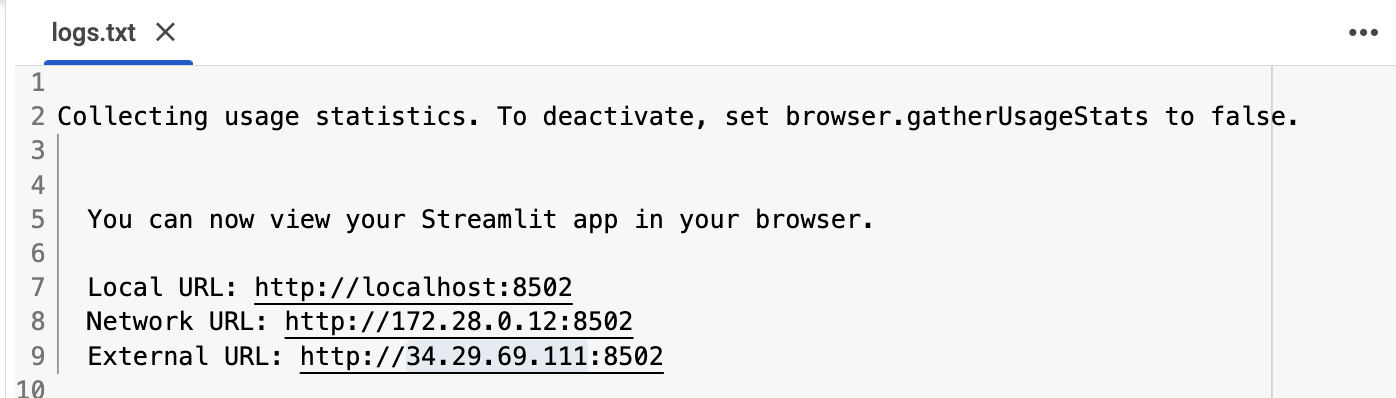

In [ ]:
!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501

⠙⠹⠸your url is: https://quiet-tigers-stay.loca.lt
/content/gdrive/.shortcut-targets-by-id/1-EuPWwH26BHpNG41utRuC3Oo7qwXYRcD/BT5153/node_modules/localtunnel/bin/lt.js:81
    throw err;
    ^

Error: connection refused: localtunnel.me:19805 (check your firewall settings)
    at Socket.<anonymous> (/content/gdrive/.shortcut-targets-by-id/1-EuPWwH26BHpNG41utRuC3Oo7qwXYRcD/BT5153/node_modules/localtunnel/lib/TunnelCluster.js:52:11)
    at Socket.emit (node:events:524:28)
    at emitErrorNT (node:internal/streams/destroy:169:8)
    at emitErrorCloseNT (node:internal/streams/destroy:128:3)
    at process.processTicksAndRejections (node:internal/process/task_queues:82:21)

Node.js v20.19.0
⠙